## Analysis of Locations

The aim of this notebook is to analyze the results we got with the Machine Learning models by locations. We want to display the results on the map and look into details into some of the locations to see what the difference between good performing and bad performing locations is 

### Import Relevant Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from mpl_toolkits.axes_grid1 import make_axes_locatable

from joblib import dump, load

In [2]:
df = pd.read_csv('../../Data/processed/weatherAUS_imputed.csv')
display(df.head())

,Date,Location,Year,Month,RainToday,RainTomorrow,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindGustDir_angle,Latitude,Longitude,Cloud,Pressure,Temperature,Humidity,temp_fluctuation
0,2009-01-01,Cobar,2009,1,0.0,0.0,-0.254034,1.452543,1.231645,0.544048,0.367568,-0.016581,0.134517,-0.346762,-1.566909,1.483789,-2.239319,1.266185
1,2009-01-02,Cobar,2009,1,0.0,0.0,-0.254034,2.092290,1.417426,-0.274399,0.142577,-0.016581,0.134517,-1.337620,-0.534263,0.523016,-2.103988,-0.123978
2,2009-01-03,Cobar,2009,1,0.0,0.0,-0.254034,1.589632,1.497046,-0.795229,-0.307405,-0.016581,0.134517,-1.337620,-0.664246,1.892307,-2.753579,1.531952
3,2009-01-04,Cobar,2009,1,0.0,0.0,-0.254034,1.178365,0.780464,0.395239,-1.432358,-0.016581,0.134517,-0.346762,-0.787008,1.756134,-1.400263,1.450178
4,2009-01-05,Cobar,2009,1,0.0,0.0,-0.254034,1.315454,1.205105,-0.720824,1.267530,-0.016581,0.134517,-0.544934,-0.765344,1.839351,-1.535595,1.102637


In [3]:
data = df.drop(columns=['RainTomorrow', 'Location', 'Date'])
target = df['RainTomorrow']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data,target,test_size=0.2,random_state=4)

In [5]:
#Function to display accuracy, preicison, recall, f1 scores by locations
def location_scores(sampler, classifier):
    locations = df.Location.unique()
    region_models = {}
    results = []

    for location in locations:
        region_data = df[df['Location'] == location]
        X_loc = region_data.drop(['RainTomorrow', 'Location', 'Date'], axis=1)
        y_loc = region_data['RainTomorrow']
        X_train_loc, X_test_loc, y_train_loc, y_test_loc = train_test_split(X_loc, y_loc, test_size=0.2, random_state=42)
        
        X_sample,y_sample= sampler.fit_resample(X_train_loc,y_train_loc)
    
        #Train Classifier for each region
        classifier.fit(X_sample, y_sample)
        region_models[location] = classifier
    
        #Score for each region
        y_pred_loc = classifier.predict(X_test_loc)
        accuracy = accuracy_score(y_test_loc, y_pred_loc)
        precision = precision_score(y_test_loc, y_pred_loc)
        recall = recall_score(y_test_loc, y_pred_loc)
        f1 = f1_score(y_test_loc, y_pred_loc)
        
        results.append({
            'Location': location,
            'Accuracy': round(accuracy, 2),
            'Precision': round(precision, 2),
            'Recall': round(recall, 2),
            'F1': round(f1, 2)
        })

    # Create DataFrame
    results_df = pd.DataFrame(results)

    return results_df

In [6]:
#function to display the confusion matrix and classification_report 
def confusion_matrix_classification_report(test, pred_test, train, pred_train):
    #calculate confusion matrix 
    conf_matrix = confusion_matrix(test, pred_test)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font scale if needed
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Confusion Matrix')
    plt.show()

    # Generate classification report
    report = classification_report(test, pred_test)

    # Print the classification report
    print('-------------------------')
    print(report)

    # Calculate accuracy for both sets
    print('-------------------------')
    train_accuracy = accuracy_score(train, pred_train)
    test_accuracy = accuracy_score(test, pred_test)
    print("Accuracy Train Set:", np.round(train_accuracy,3), "Accuracy Test Set:", np.round(test_accuracy,3))

In [7]:
#function for train_test_split best location 
def best_location_train_test_split(best_locations):
    
    #create best location data frame
    df_best_loc = df[df.Location.isin(best_locations.Location)]
    
    #define data and target with best locations data frame
    data_best = df_best_loc.drop(columns=['RainTomorrow', 'Location', 'Date'])
    target_best = df_best_loc['RainTomorrow']
    
    #train_test_split
    X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(data_best,target_best,test_size=0.2,random_state=4)
    return X_train_best, X_test_best, y_train_best, y_test_best

### Display locations on a map 

In [8]:
df.sort_values(by='Location').Location.unique()

array(['AliceSprings', 'Brisbane', 'Cairns', 'Canberra', 'Cobar',
       'CoffsHarbour', 'Darwin', 'Hobart', 'MelbourneAirport', 'Mildura',
       'Moree', 'MountGambier', 'NorfolkIsland', 'Nuriootpa',
       'PerthAirport', 'Portland', 'Sale', 'SydneyAirport', 'Townsville',
       'WaggaWagga', 'Watsonia', 'Williamtown', 'Woomera'], dtype=object)

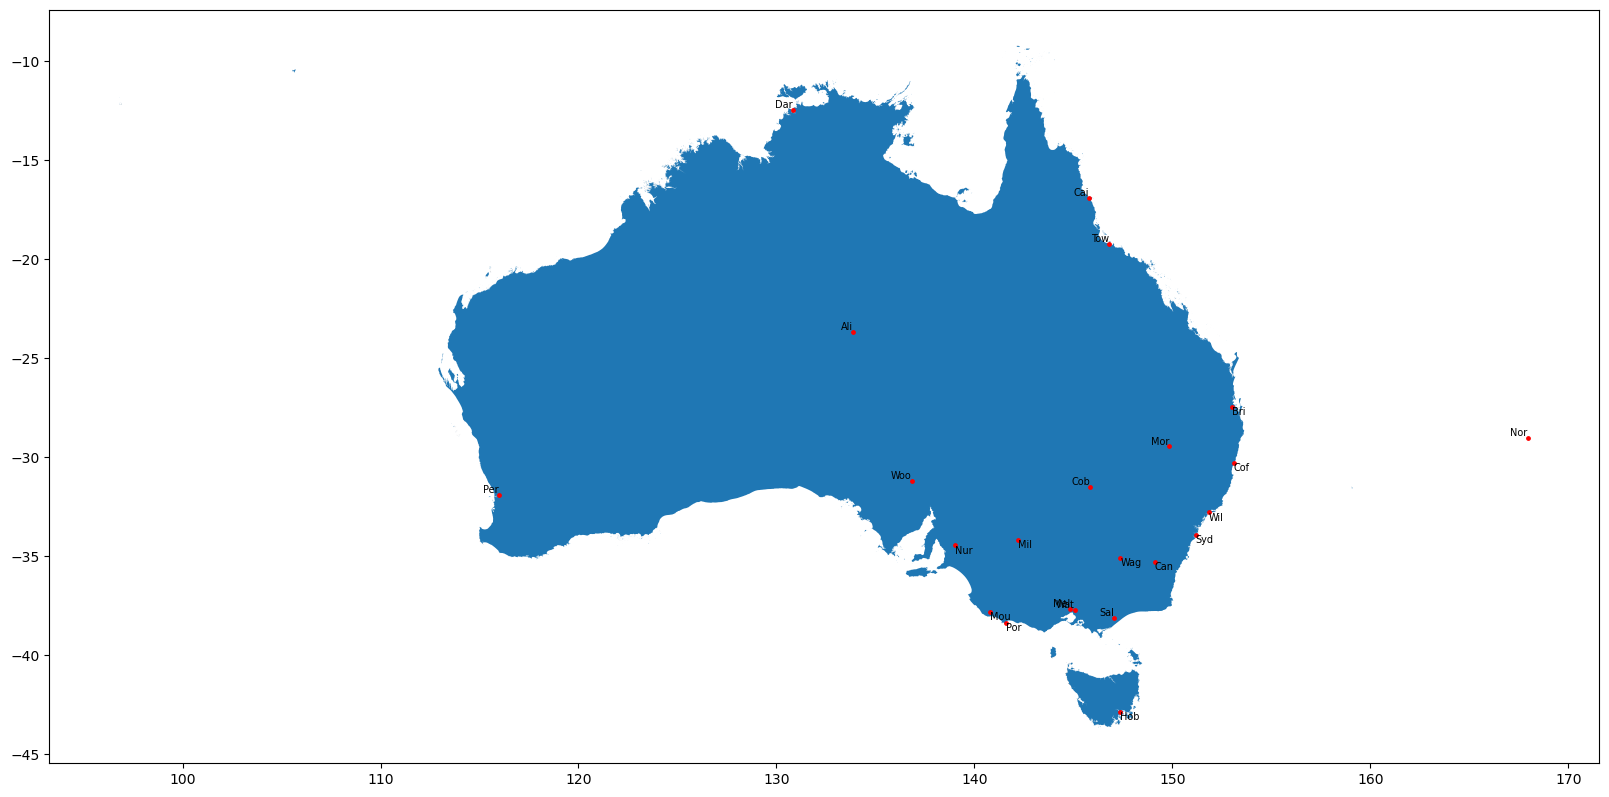

In [9]:
cities = df.Location.unique()

# Empty list to store coordinates
coordinates = [
     (-23.698, 133.8816, 'Alice Springs'),
     (-27.4689682, 153.0234991, 'Brisbane'),
     (-16.9206, 145.7709, 'Cairns'),
     (-35.2975906, 149.1012676, 'Canberra'),
     (-31.4983333, 145.8347222, 'Cobar'),
     (-30.296241, 153.113529, 'Coffs Harbour'),
     (-12.4628, 130.8417, 'Darwin'),
     (-42.8825, 147.33, 'Hobart'),
     (-37.6697, 144.8491, 'Melbourne Airport'),
     (-34.2029, 142.2202, 'Mildura'),
     (-29.4648, 149.8415, 'Moree'),
     (-37.8284, 140.7801, 'Mount Gambier'),
     (-29.0283, 167.948, 'Norfolk Island'),
     (-34.4683, 138.9958, 'Nuriootpa'),
     (-31.9374, 115.9665, 'Perth Airport'),
     (-38.3635, 141.6053, 'Portland'),
     (-38.1075, 147.0636, 'Sale'),
     (-33.9399227, 151.1752769, 'Sydney Airport'), 
     (-19.2569391, 146.8239536, 'Townsville'),
     (-35.115, 147.3677778, 'Wagga Wagga'),
     (-37.7108, 145.0833, 'Watsonia'),
     (-32.7986, 151.842, 'Williamtown'),
     (-31.1994, 136.8254, 'Woomera')]


# Path to the shapefile
shapefile_path = "../../Data/map/AUS_2021_AUST_GDA2020.shp"


# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Convert coordinates to GeoDataFrame
gdf_coordinates = gpd.GeoDataFrame(geometry=gpd.points_from_xy([coord[1] for coord in coordinates], [coord[0] for coord in coordinates]))

# Plot the shapefile
ax = gdf.plot(figsize=(20, 20))

# Plot the coordinates
gdf_coordinates.plot(ax=ax, color='red', marker='o', markersize=6)

# Annotate the points with names
counter = 0
for x, y, name in coordinates:
    counter += 1
    ha = 'left' if counter % 2 == 0 else 'right'
    # Alternate vertical alignment
    va = 'top' if counter % 2 == 0 else 'bottom'
    ax.text(y, x,name[:3],fontsize=7, ha=ha, va=va)

### 1. Map Visualization KNN with Random Undersampling

In [10]:
rus = RandomUnderSampler()

In [11]:
knn = KNeighborsClassifier(n_neighbors=23, metric="manhattan")

In [12]:
df_knn_loc = location_scores(rus, knn)

In [13]:
#Create the GeoDataFrame by combining the DataFrame and GeoSeries
results_knn_loc = gpd.GeoDataFrame(df_knn_loc, geometry=gpd.points_from_xy([coord[1] for coord in coordinates], [coord[0] for coord in coordinates]))

### 1.1 Visualization of KNN Model Accuracy

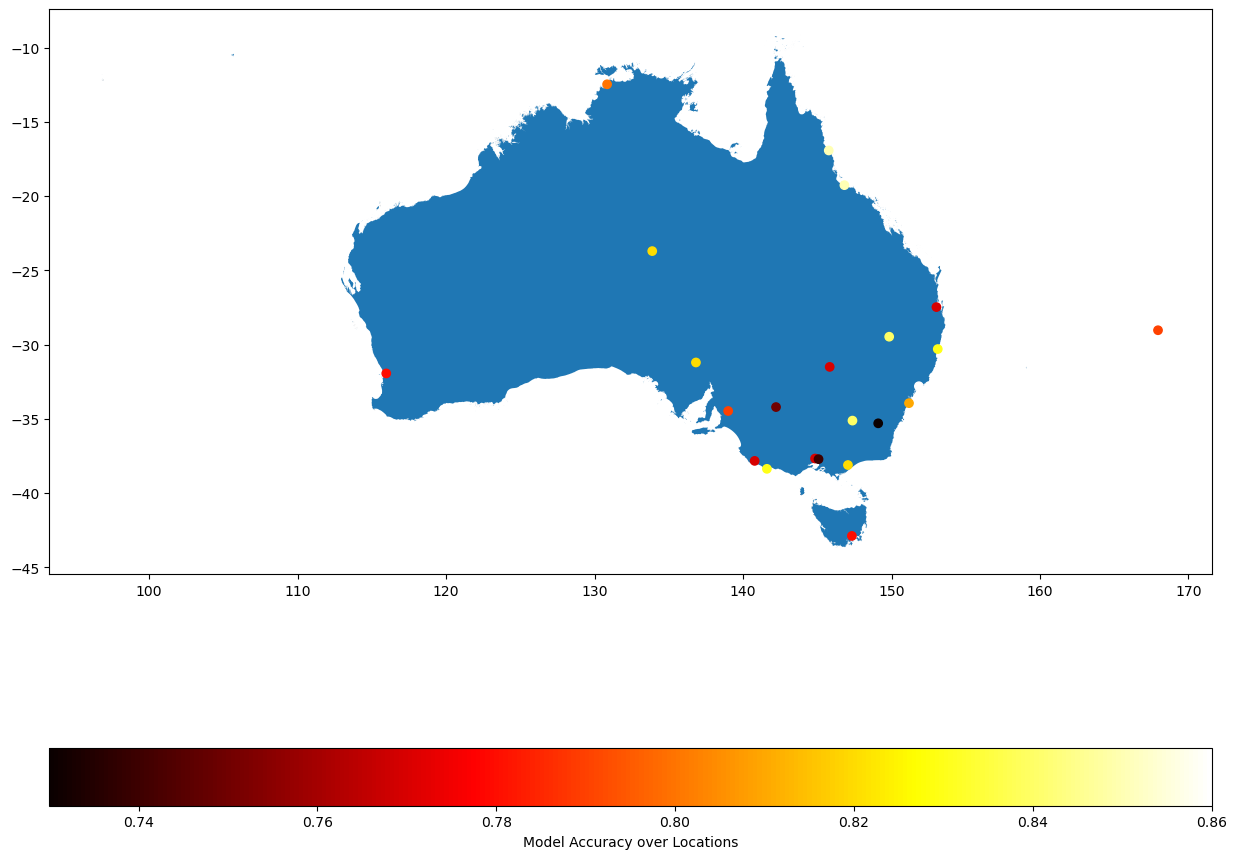

In [14]:
ax = gdf.plot(figsize=(15, 15))

results_knn_loc.plot(
    column="Accuracy",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Model Accuracy over Locations", "orientation": "horizontal"},
);

### 1.2 Visualization of KNN Precision Score 

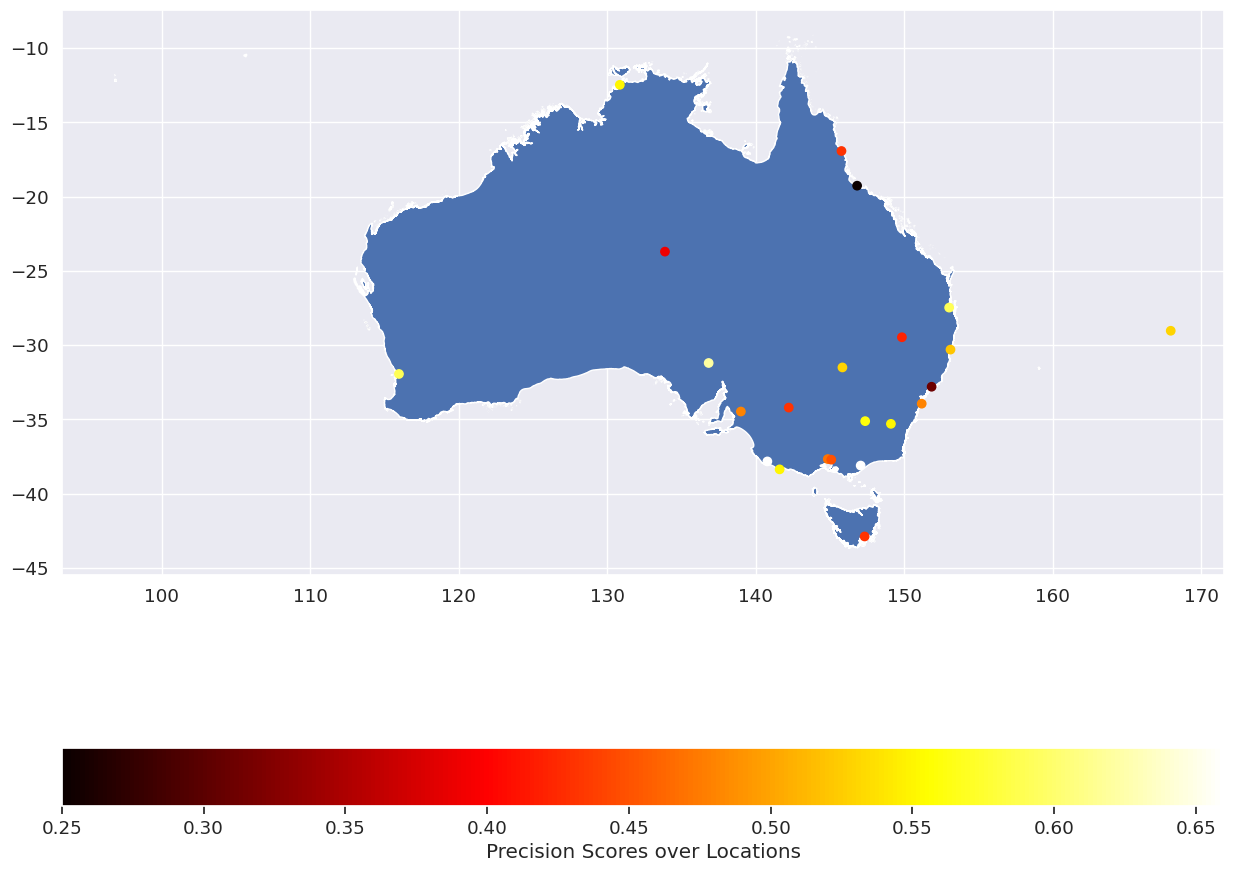

In [72]:
ax = gdf.plot(figsize=(15, 15))

results_knn_loc.plot(
    column="Precision",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Precision Scores over Locations", "orientation": "horizontal"},
);

### 1.3 Visualization of KNN Recall Score

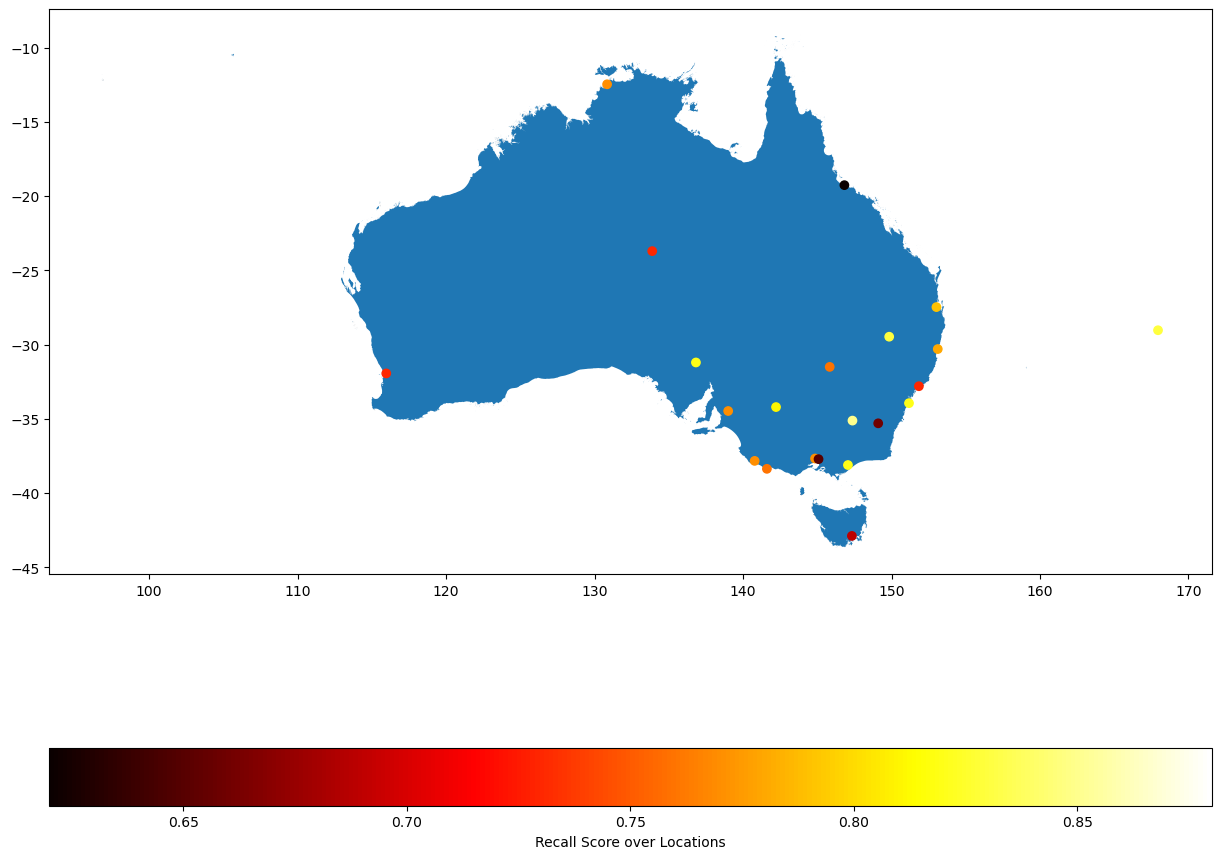

In [16]:
ax = gdf.plot(figsize=(15, 15))

results_knn_loc.plot(
    column="Recall",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Recall Scores over Locations", "orientation": "horizontal"},
);

### 1.4 Analysis for locations with best accuracy scores 

In [17]:
best_locations = results_knn_loc[results_knn_loc.Accuracy >= 0.80]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [18]:
X_resampled,y_resampled = rus.fit_resample(X_train_best,y_train_best)

In [19]:
knn.fit(X_resampled,y_resampled)

KNeighborsClassifier(metric='manhattan', n_neighbors=23)

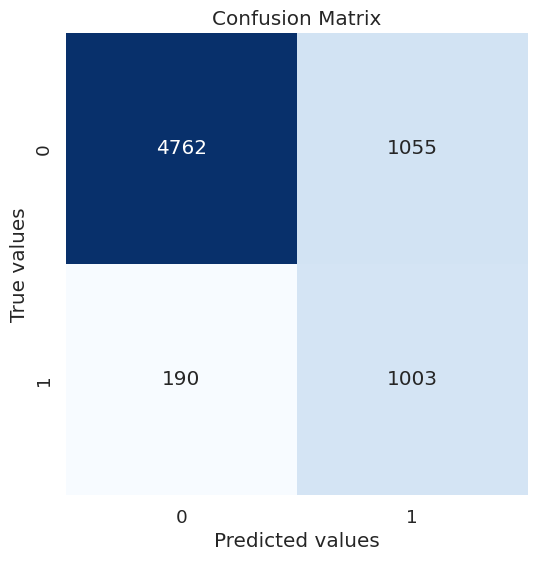

-------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.82      0.88      5817
         1.0       0.49      0.84      0.62      1193

    accuracy                           0.82      7010
   macro avg       0.72      0.83      0.75      7010
weighted avg       0.88      0.82      0.84      7010

-------------------------
Accuracy Train Set: 0.829 Accuracy Test Set: 0.822


In [20]:
y_pred_knn = knn.predict(X_test_best)
y_pred_train_knn = knn.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_knn, y_train_best, y_pred_train_knn)

### 1.5 Analysis for locations with best precision scores 

In [21]:
best_locations = results_knn_loc[results_knn_loc.Precision >= 0.60]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [22]:
X_resampled,y_resampled = rus.fit_resample(X_train_best,y_train_best)

In [23]:
knn.fit(X_resampled,y_resampled)

KNeighborsClassifier(metric='manhattan', n_neighbors=23)

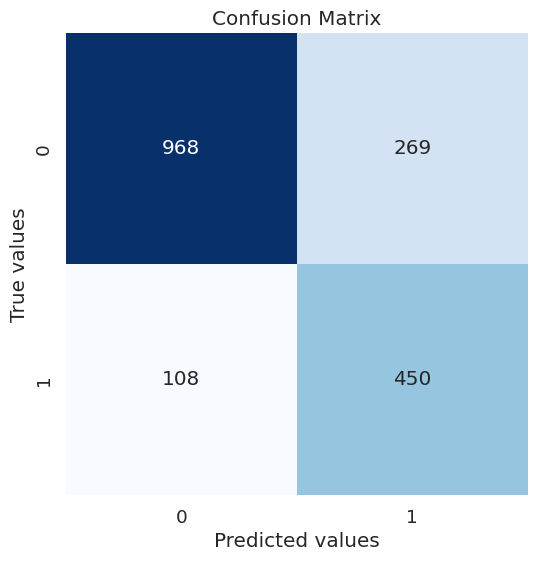

-------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.78      0.84      1237
         1.0       0.63      0.81      0.70       558

    accuracy                           0.79      1795
   macro avg       0.76      0.79      0.77      1795
weighted avg       0.81      0.79      0.80      1795

-------------------------
Accuracy Train Set: 0.803 Accuracy Test Set: 0.79


In [24]:
y_pred_knn = knn.predict(X_test_best)
y_pred_train_knn = knn.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_knn, y_train_best, y_pred_train_knn)

### 1.6 Analysis for locations with best recall scores

In [25]:
best_locations = results_knn_loc[results_knn_loc.Recall >= 0.80]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [26]:
X_resampled,y_resampled = rus.fit_resample(X_train_best,y_train_best)

In [27]:
knn.fit(X_resampled,y_resampled)

KNeighborsClassifier(metric='manhattan', n_neighbors=23)

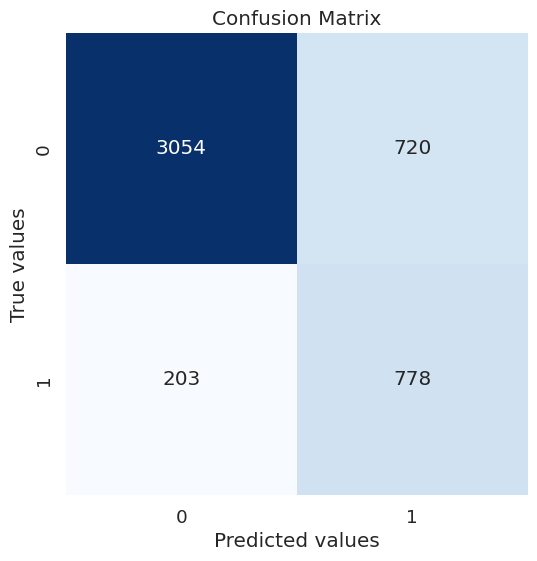

-------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.81      0.87      3774
         1.0       0.52      0.79      0.63       981

    accuracy                           0.81      4755
   macro avg       0.73      0.80      0.75      4755
weighted avg       0.85      0.81      0.82      4755

-------------------------
Accuracy Train Set: 0.818 Accuracy Test Set: 0.806


In [28]:
y_pred_knn = knn.predict(X_test_best)
y_pred_train_knn = knn.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_knn, y_train_best, y_pred_train_knn)

-------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.79      0.85     10663
         1.0       0.50      0.80      0.62      2882

    accuracy                           0.79     13545
   macro avg       0.72      0.79      0.74     13545
weighted avg       0.84      0.79      0.80     13545

-------------------------
Accuracy Train Set: 0.801 Accuracy Test Set: 0.79

### 2.Map Visualization Decision Tree SMOTE, best parameter and adaptive boosting

In [31]:
sm = SMOTE()

In [32]:
dt_ac_fit = load('dt_ac_fit.joblib')

In [33]:
df_dt_loc = location_scores(sm, dt_ac_fit)

In [34]:
# Create the GeoDataFrame by combining the DataFrame and GeoSeries
results_dt_loc = gpd.GeoDataFrame(df_dt_loc, geometry=gpd.points_from_xy([coord[1] for coord in coordinates], [coord[0] for coord in coordinates]))

### 2.1 Visualization Decision Tree Model Accuracy

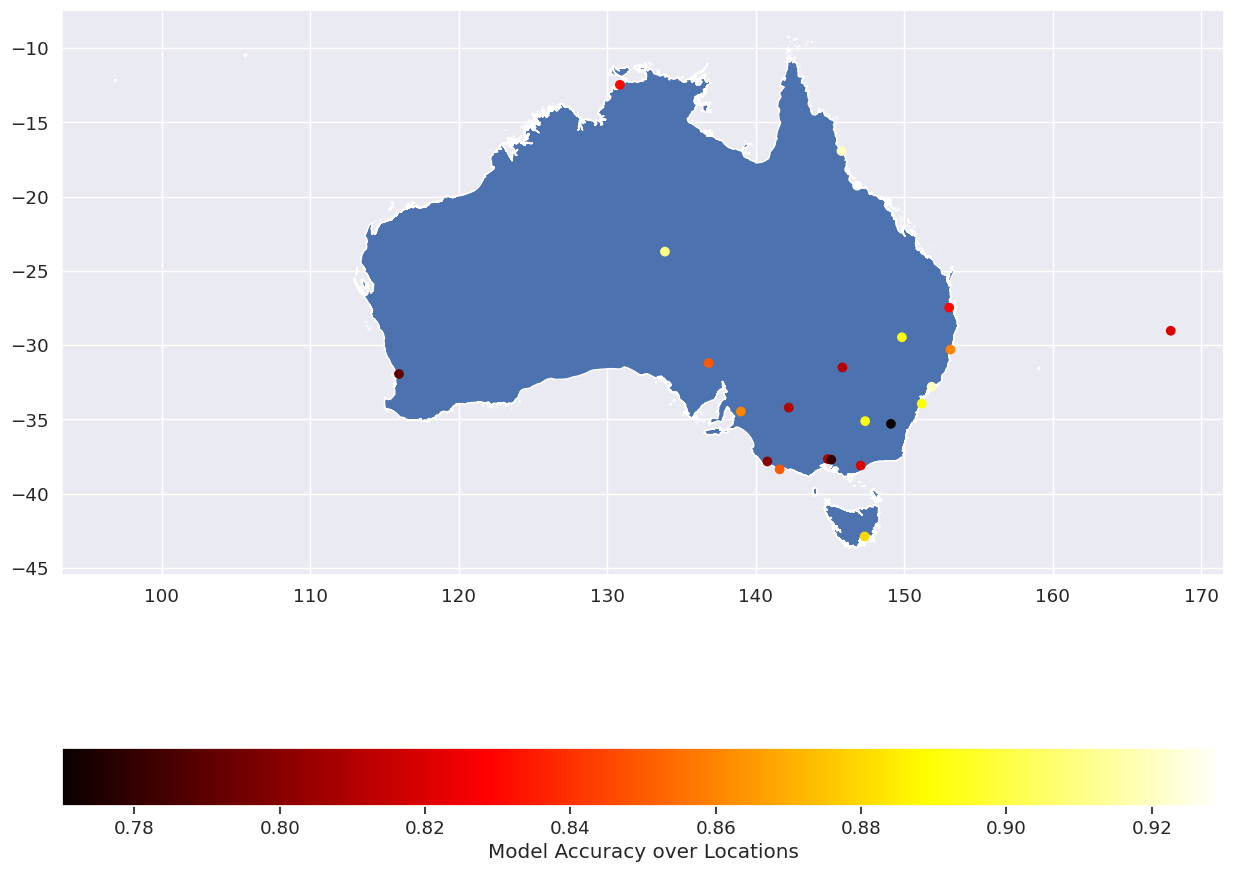

In [35]:
ax = gdf.plot(figsize=(15, 15))

results_dt_loc.plot(
    column="Accuracy",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Model Accuracy over Locations", "orientation": "horizontal"},
);

### 2.2 Visualization Decision Tree Precision Score

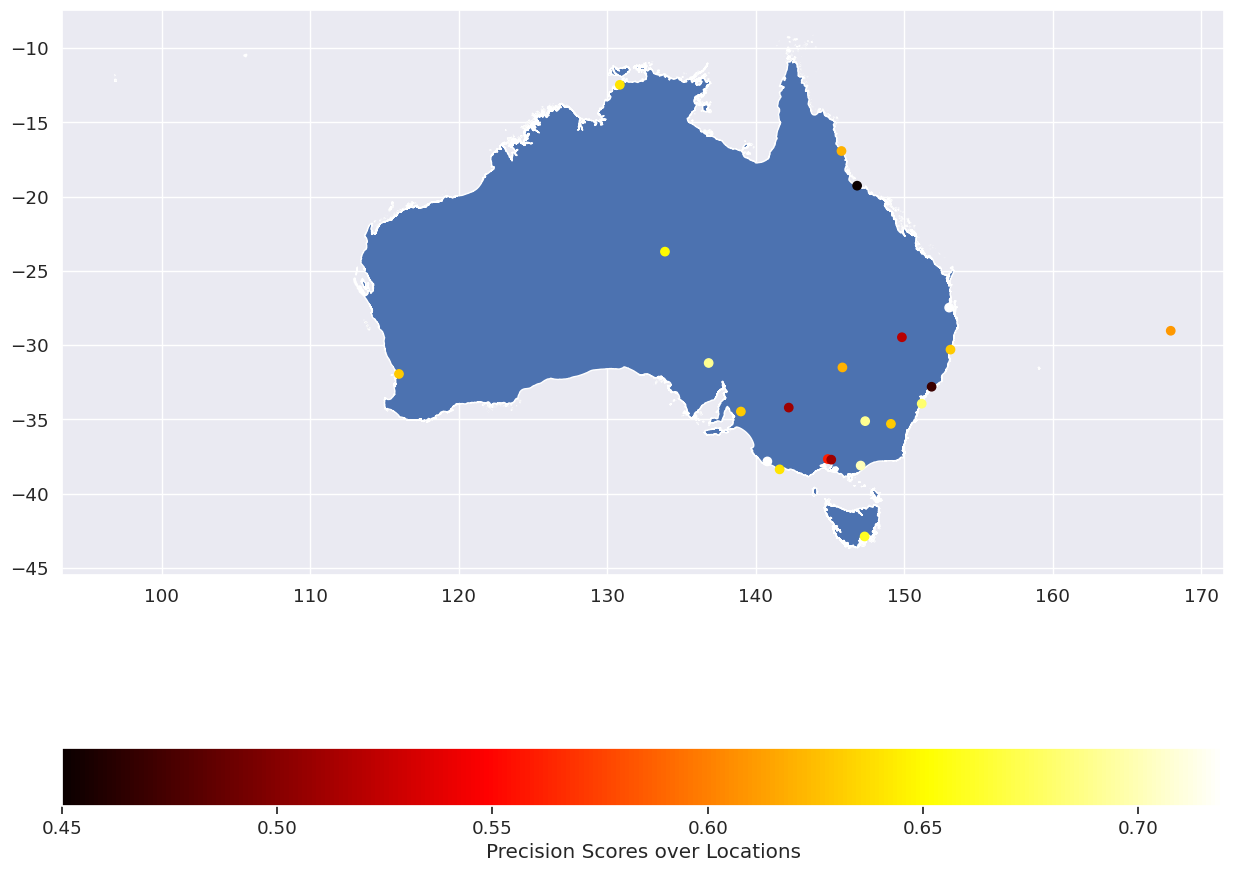

In [75]:
ax = gdf.plot(figsize=(15, 15))

results_dt_loc.plot(
    column="Precision",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Precision Scores over Locations", "orientation": "horizontal"},
);

### 2.3 Visualization Decision Tree Recall Score

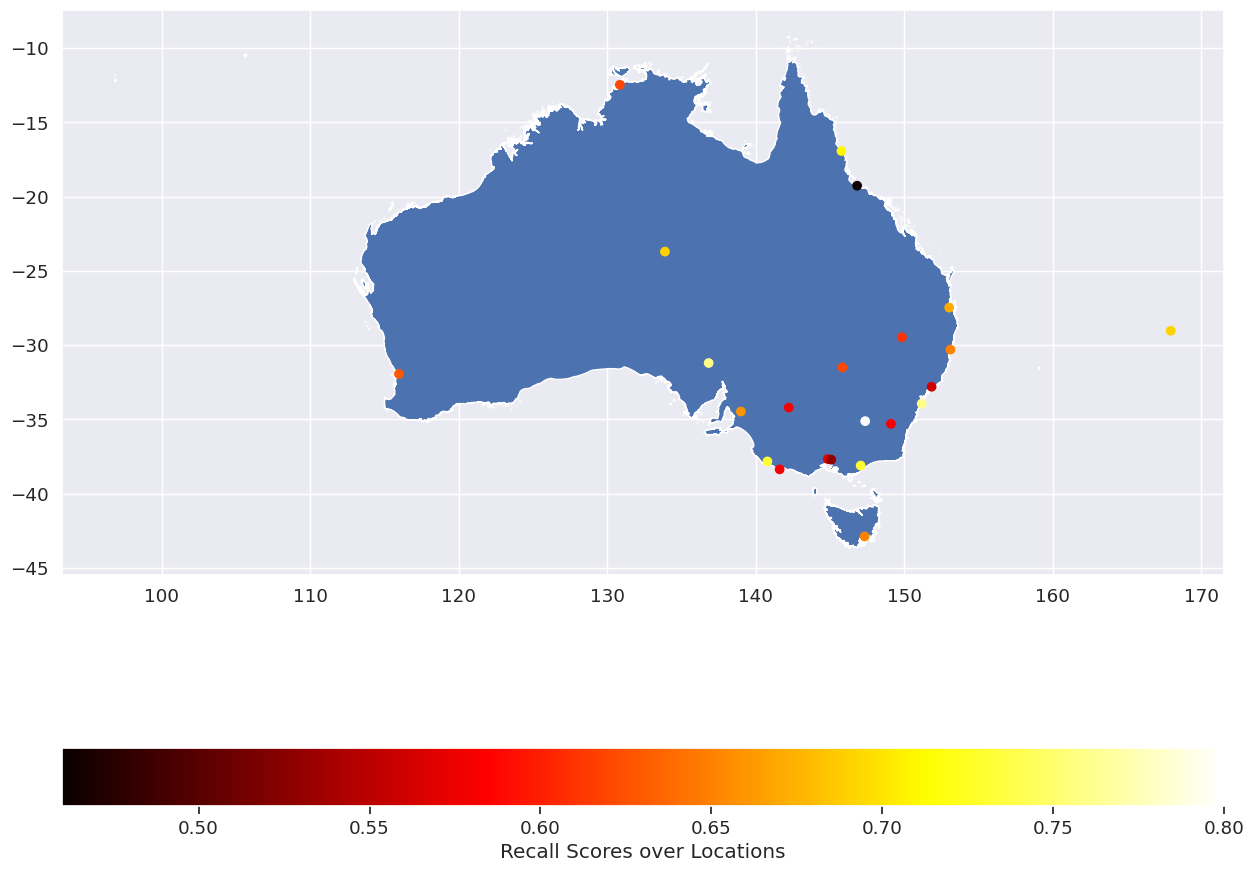

In [37]:
ax = gdf.plot(figsize=(15, 15))

results_dt_loc.plot(
    column="Recall",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Recall Scores over Locations", "orientation": "horizontal"},
);

### 2.4 Analysis for locations with best accuracy socres

In [38]:
best_locations = results_dt_loc[results_dt_loc.Accuracy >= 0.80]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [39]:
X_resampled,y_resampled = sm.fit_resample(X_train_best,y_train_best)

In [40]:
dt_ac_fit.fit(X_resampled,y_resampled)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=11,
                                                         random_state=42),
                   n_estimators=400)

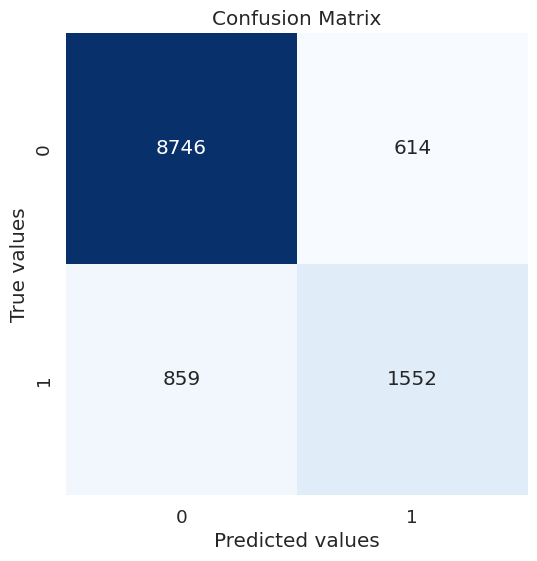

-------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      9360
         1.0       0.72      0.64      0.68      2411

    accuracy                           0.87     11771
   macro avg       0.81      0.79      0.80     11771
weighted avg       0.87      0.87      0.87     11771

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.875


In [41]:
y_pred_ac = dt_ac_fit.predict(X_test_best)
y_pred_train_ac = dt_ac_fit.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_ac, y_train_best, y_pred_train_ac)

### 2.5 Analysis for locations with best precision scores 

In [42]:
best_locations = results_dt_loc[results_dt_loc.Precision >= 0.70]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [43]:
X_resampled,y_resampled = sm.fit_resample(X_train_best,y_train_best)

In [44]:
dt_ac_fit.fit(X_resampled,y_resampled)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=11,
                                                         random_state=42),
                   n_estimators=400)

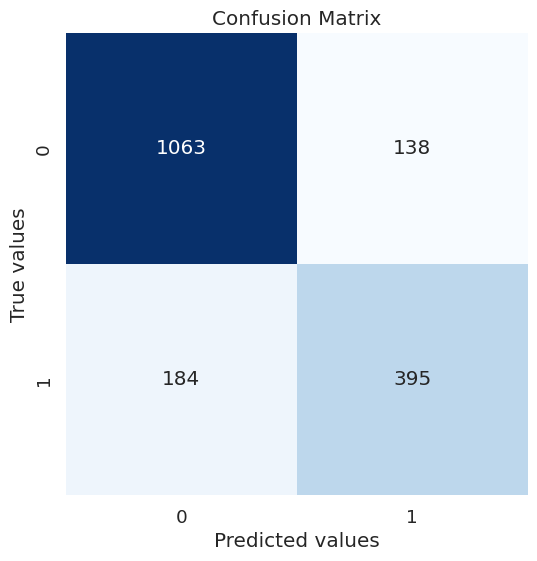

-------------------------
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      1201
         1.0       0.74      0.68      0.71       579

    accuracy                           0.82      1780
   macro avg       0.80      0.78      0.79      1780
weighted avg       0.82      0.82      0.82      1780

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.819


In [45]:
y_pred_ac = dt_ac_fit.predict(X_test_best)
y_pred_train_ac = dt_ac_fit.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_ac, y_train_best, y_pred_train_ac)

### 2.6 Analysis for locations with best recall scores 

In [46]:
best_locations = results_dt_loc[results_dt_loc.Recall >= 0.70]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [47]:
X_resampled,y_resampled = sm.fit_resample(X_train_best,y_train_best)

In [48]:
dt_ac_fit.fit(X_resampled,y_resampled)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=11,
                                                         random_state=42),
                   n_estimators=400)

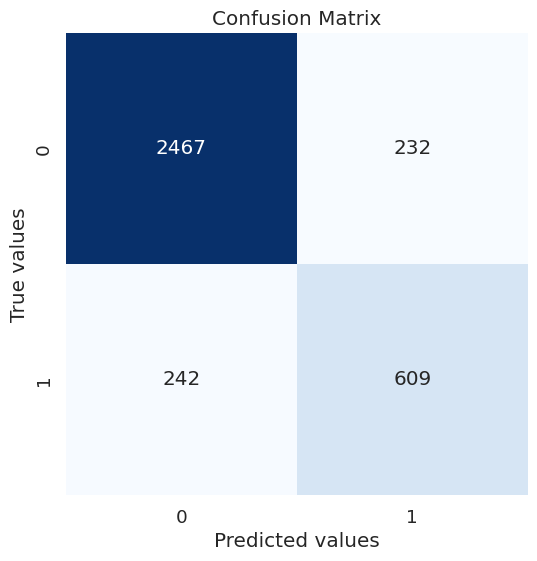

-------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      2699
         1.0       0.72      0.72      0.72       851

    accuracy                           0.87      3550
   macro avg       0.82      0.81      0.82      3550
weighted avg       0.87      0.87      0.87      3550

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.866


In [49]:
y_pred_ac = dt_ac_fit.predict(X_test_best)
y_pred_train_ac = dt_ac_fit.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_ac, y_train_best, y_pred_train_ac)

### Best result for all locations

-------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91     10663
         1.0       0.69      0.64      0.66      2882

    accuracy                           0.86     13545
   macro avg       0.80      0.78      0.79     13545
weighted avg       0.86      0.86      0.86     13545

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.861

### 3. Map Visualization Random Forest Classifier with Random Oversampling

In [50]:
ros = RandomOverSampler()

In [51]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=321)

In [52]:
df_rfc_loc = location_scores(ros, rfc)

In [53]:
# Create the GeoDataFrame by combining the DataFrame and GeoSeries
results_rfc_loc = gpd.GeoDataFrame(df_rfc_loc, geometry=gpd.points_from_xy([coord[1] for coord in coordinates], [coord[0] for coord in coordinates]))

### 3.1 Visualization of Random Forest Model Accuracy

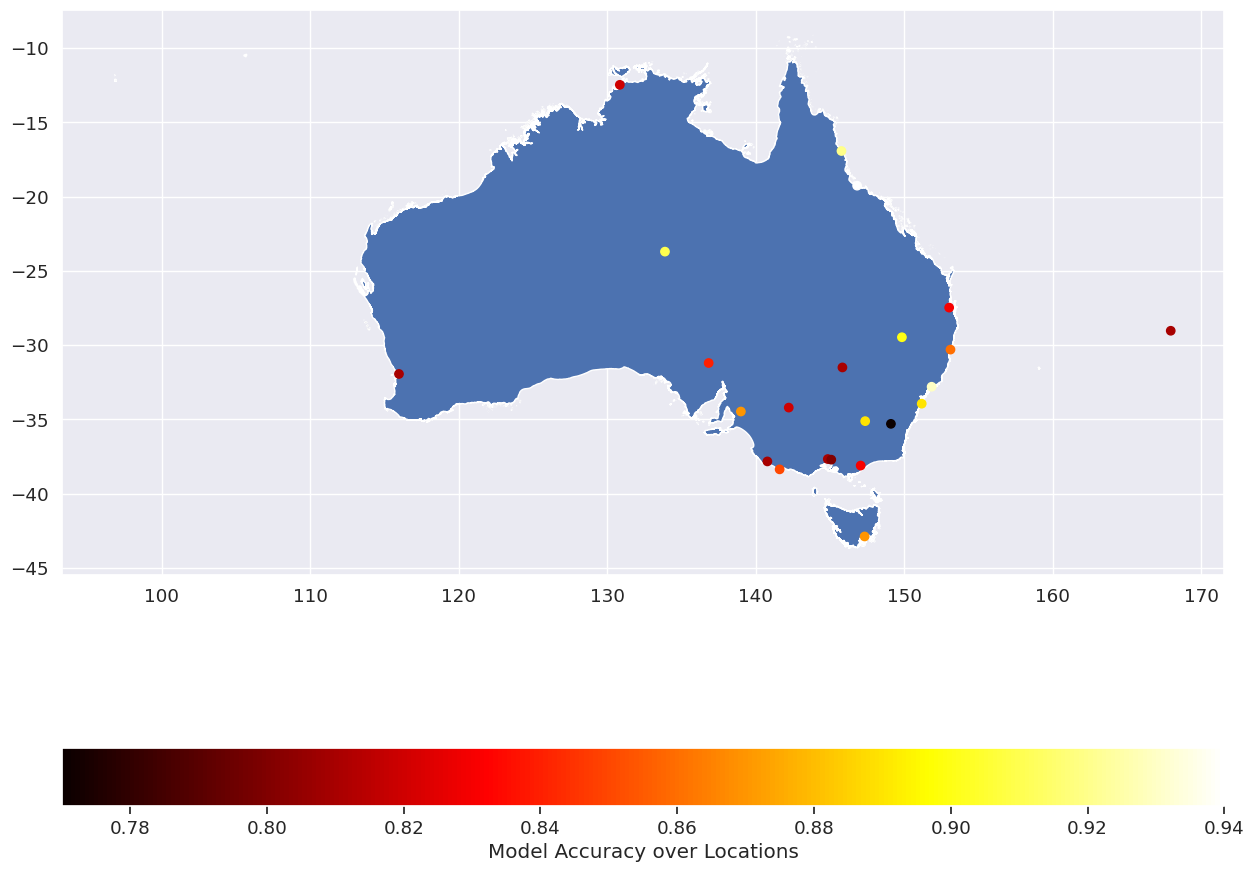

In [54]:
ax = gdf.plot(figsize=(15, 15))

results_rfc_loc.plot(
    column="Accuracy",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Model Accuracy over Locations", "orientation": "horizontal"},
);

### 3.2 Visualization of Random Forest Precision Score

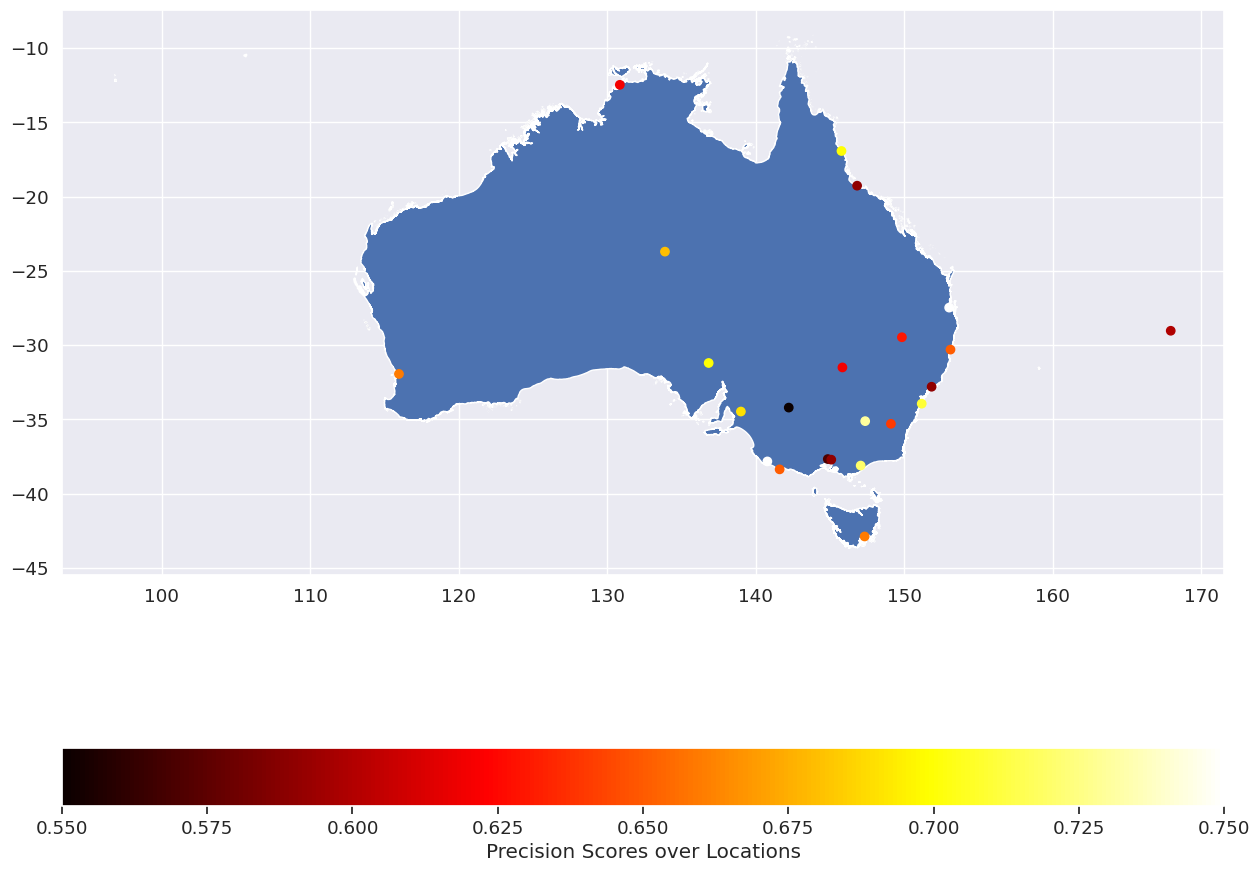

In [74]:
ax = gdf.plot(figsize=(15, 15))

results_rfc_loc.plot(
    column="Precision",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Precision Scores over Locations", "orientation": "horizontal"},
);

### 3.3 Visualization of Random Forest Recall Score

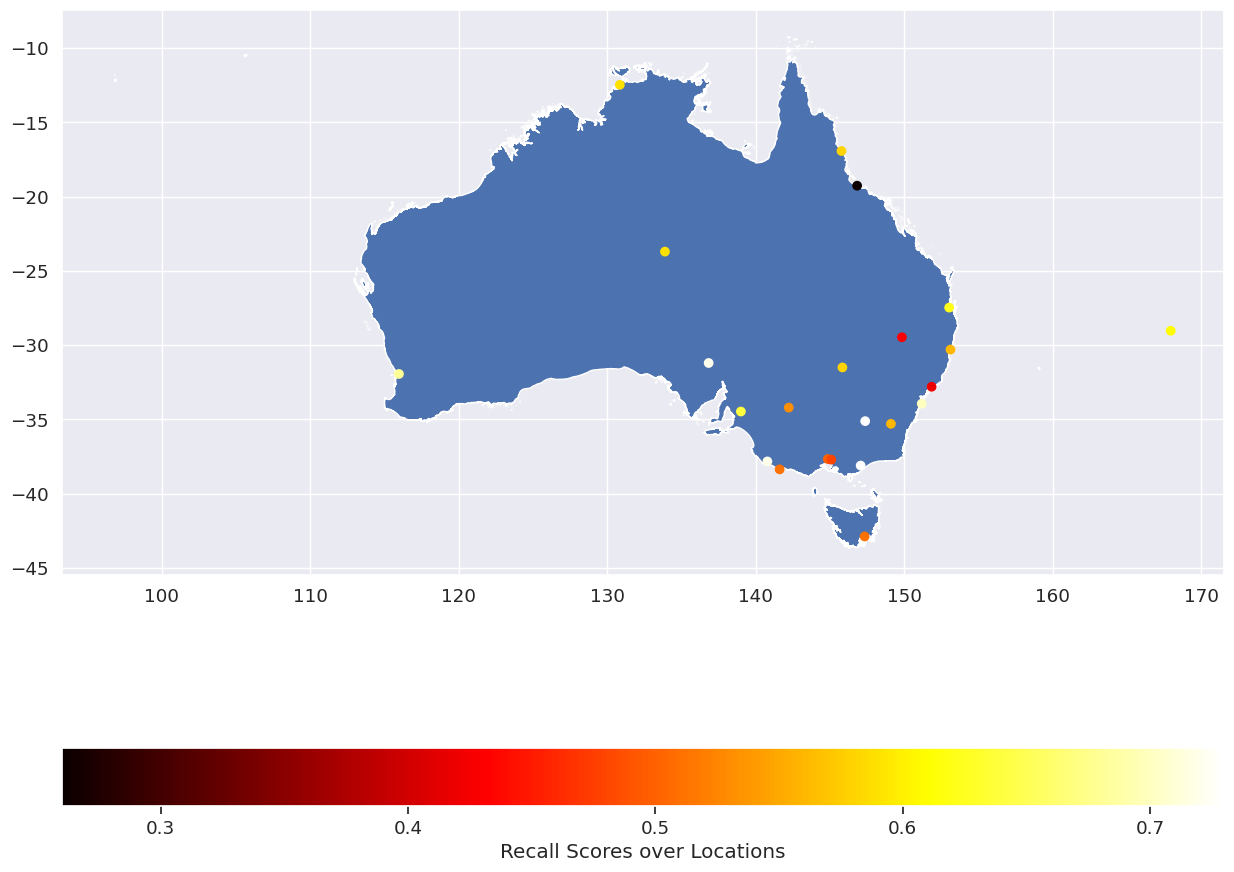

In [73]:
ax = gdf.plot(figsize=(15, 15))

results_rfc_loc.plot(
    column="Recall",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Recall Scores over Locations", "orientation": "horizontal"},
);

### 3.4 Analysis for locations with best accuracy scores

In [57]:
best_locations = results_rfc_loc[results_dt_loc.Accuracy >= 0.80]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [58]:
X_resampled,y_resampled = ros.fit_resample(X_train_best,y_train_best)

In [59]:
rfc.fit(X_resampled,y_resampled)

RandomForestClassifier(n_jobs=-1, random_state=321)

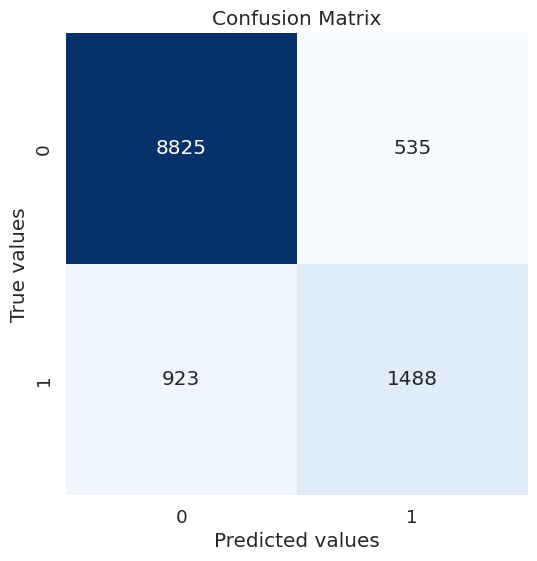

-------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.94      0.92      9360
         1.0       0.74      0.62      0.67      2411

    accuracy                           0.88     11771
   macro avg       0.82      0.78      0.80     11771
weighted avg       0.87      0.88      0.87     11771

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.876


In [60]:
y_pred_rfc = rfc.predict(X_test_best)
y_pred_train_rfc = rfc.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_rfc, y_train_best, y_pred_train_rfc)

### 3.5 Analysis for locations with best precision scores

In [61]:
best_locations = results_rfc_loc[results_dt_loc.Precision >= 0.70]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [62]:
X_resampled,y_resampled = ros.fit_resample(X_train_best,y_train_best)

In [63]:
rfc.fit(X_resampled,y_resampled)

RandomForestClassifier(n_jobs=-1, random_state=321)

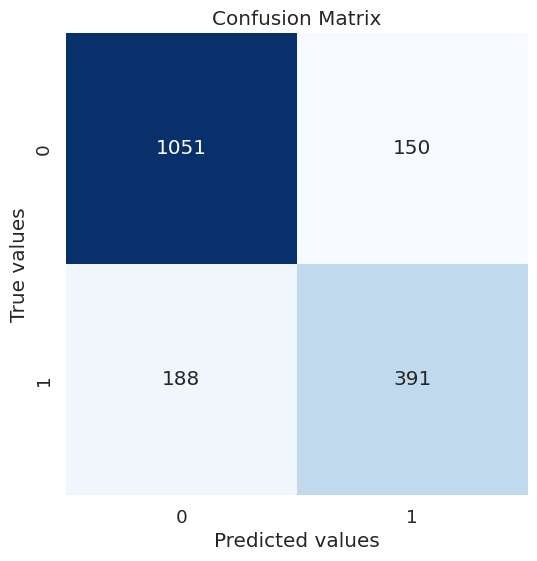

-------------------------
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86      1201
         1.0       0.72      0.68      0.70       579

    accuracy                           0.81      1780
   macro avg       0.79      0.78      0.78      1780
weighted avg       0.81      0.81      0.81      1780

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.81


In [64]:
y_pred_rfc = rfc.predict(X_test_best)
y_pred_train_rfc = rfc.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_rfc, y_train_best, y_pred_train_rfc)

### 3.6 Analysis for locations with best recall scores

In [65]:
best_locations = results_rfc_loc[results_dt_loc.Recall >= 0.70]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [66]:
X_resampled,y_resampled = ros.fit_resample(X_train_best,y_train_best)

In [67]:
rfc.fit(X_resampled,y_resampled)

RandomForestClassifier(n_jobs=-1, random_state=321)

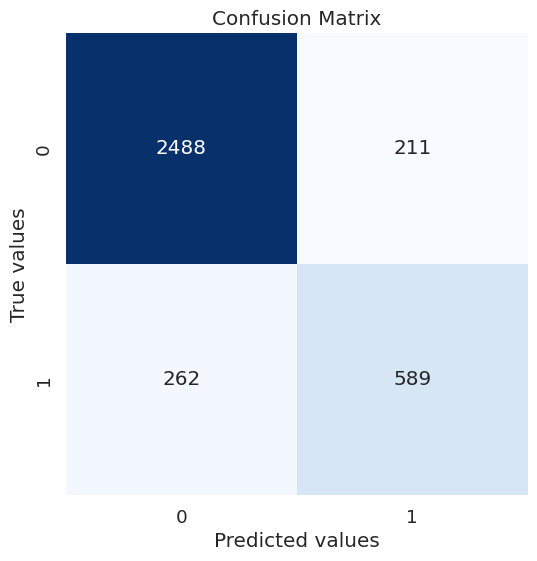

-------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91      2699
         1.0       0.74      0.69      0.71       851

    accuracy                           0.87      3550
   macro avg       0.82      0.81      0.81      3550
weighted avg       0.86      0.87      0.87      3550

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.867


In [68]:
y_pred_rfc = rfc.predict(X_test_best)
y_pred_train_rfc = rfc.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_rfc, y_train_best, y_pred_train_rfc)

-------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91     10663
         1.0       0.70      0.61      0.65      2882

    accuracy                           0.86     13545
   macro avg       0.80      0.77      0.78     13545
weighted avg       0.85      0.86      0.86     13545

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.86